In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = config["image_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset(PATH_TO_IMAGES,['no_sub'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
phy_loss = models.SersicProfiler(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, resolution=resolution, device=device, alpha=alpha, BATCH_SIZE=BATCH_SIZE, sersic_args = [20, 1, 0.25])


In [6]:
def give_random_image(dataset, model1, length, i=None, plot=True):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    image = model1(t.float().to(device)).cpu().detach()
    sersic_profile, source_profile = phy_loss.get_sample(image, plot)
    image1 = Image.fromarray(image.numpy()[0][0]*255)
    image2 = Image.fromarray(sersic_profile.cpu().detach().numpy()*255)
    # image3 = Image.fromarray(source_profile.cpu().detach().numpy()[0][0]*255)
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2)

def show_random_image(image_tuple):
    image0, image1, image2 = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Re-lensing profile")

In [8]:
i_model.load_state_dict(torch.load('i_weight_post.pt'))

<All keys matched successfully>

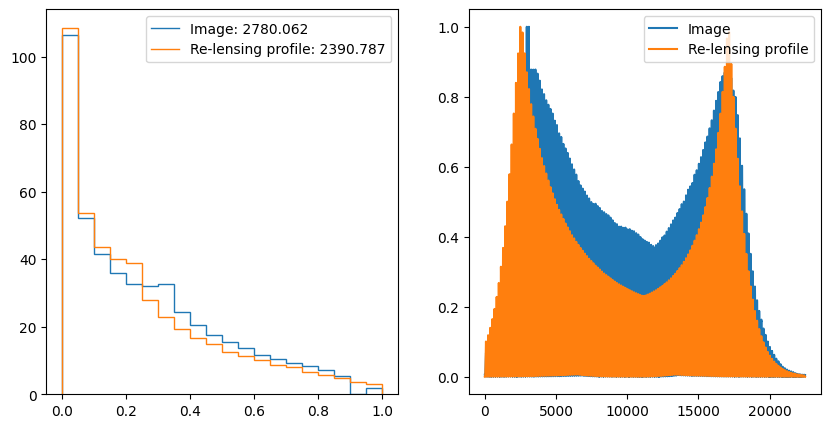

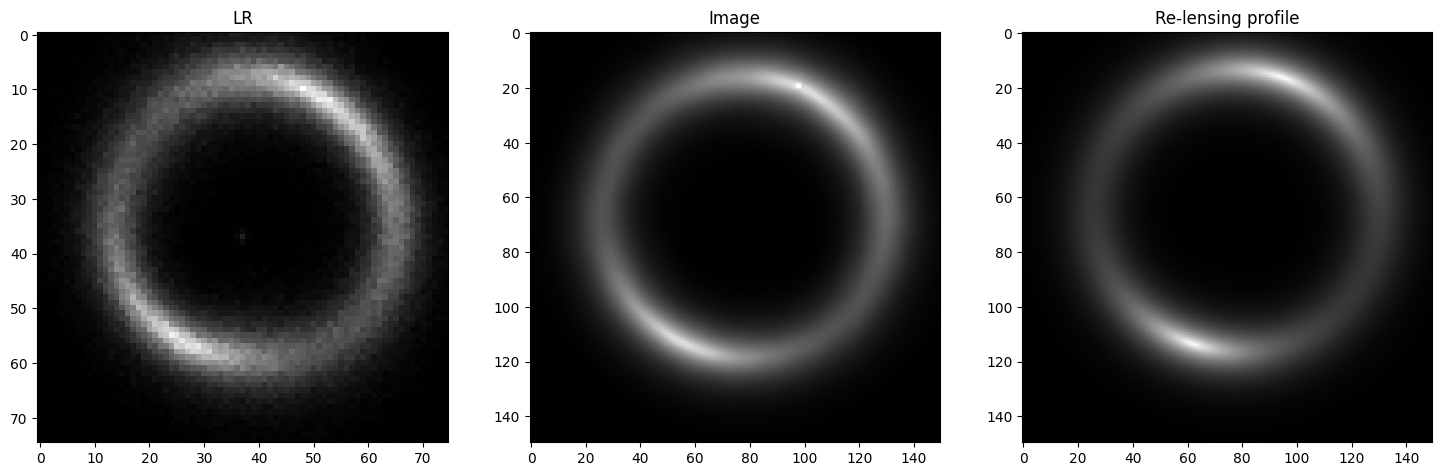

In [13]:
show_random_image(give_random_image(val_dataset, i_model, len(val_dataset)))